# Data Mining Challenge 2020

## Team
* Diego Cumming 10709685

### To get the prediction, please go to DMTM2020-Challenge-Part5-Prediction.ipynb


In [1]:
''' PACKAGES'''
import pandas as pd             

import numpy as np

import seaborn as sns
sns.set(style="dark", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   


import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime as dt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist

In [2]:
''' DATA PRE-PROCESSING'''
df=pd.read_csv('train.csv')
df.rename(columns={'Unnamed: 0':'week', 'size (GM)':'size', 'POS_exposed w-1':'nos_w-1', 'volume_on_promo w-1':'vop_w-1',
                   'sales w-1':'sales_w-1'},inplace=True)
df['sku']=df['sku'].apply(str)
df['week'] = df['week'].map(lambda x: x.lstrip('WE '))
def dateFormat(date_str):
    return dt.strptime(date_str, '%d %B %Y')
df['week']=df['week'].apply(dateFormat)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5719 entries, 0 to 5718
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   week       5719 non-null   datetime64[ns]
 1   sku        5719 non-null   object        
 2   pack       5719 non-null   object        
 3   size       5719 non-null   float64       
 4   brand      5719 non-null   object        
 5   price      5719 non-null   float64       
 6   nos_w-1    5676 non-null   float64       
 7   vop_w-1    5676 non-null   float64       
 8   sales_w-1  5676 non-null   float64       
 9   scope      5719 non-null   int64         
 10  target     5719 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 491.6+ KB


In [4]:
skus=df['sku'].drop_duplicates().reset_index(drop=True)
skus_s=df.loc[df['scope']==1]['sku'].drop_duplicates().reset_index(drop=True)
week=df['week'].drop_duplicates().reset_index(drop=True).to_frame()

In [5]:
### Time series of All SKU
target=week.copy()
price=week.copy()
nos_w1=week.copy()
vop_w1=week.copy()
sales_w1=week.copy()
for index, row in skus.items():
    target[row]=df[df['sku']==row].reset_index()['target']
    price[row]=df[df['sku']==row].reset_index()['price']
    nos_w1[row]=df[df['sku']==row].reset_index()['nos_w-1']
    vop_w1[row]=df[df['sku']==row].reset_index()['vop_w-1']
    sales_w1[row]=df[df['sku']==row].reset_index()['sales_w-1']
target.set_index('week',inplace=True)
price.set_index('week',inplace=True)
nos_w1.set_index('week',inplace=True)
vop_w1.set_index('week',inplace=True)
sales_w1.set_index('week',inplace=True)
nos_w1.dropna(inplace=True)
vop_w1.dropna(inplace=True)
sales_w1.dropna(inplace=True)
### Time series of Scope SKU
target_s=week.copy()
price_s=week.copy()
nos_w1_s=week.copy()
vop_w1_s=week.copy()
sales_w1_s=week.copy()
for index, row in skus.items():
    if df[df['sku']==row]['scope'].iloc[0]==1:
        target_s[row]=df[df['sku']==row].reset_index()['target']
        price_s[row]=df[df['sku']==row].reset_index()['price']
        nos_w1_s[row]=df[df['sku']==row].reset_index()['nos_w-1']
        vop_w1_s[row]=df[df['sku']==row].reset_index()['vop_w-1']
        sales_w1_s[row]=df[df['sku']==row].reset_index()['sales_w-1']
target_s.set_index('week',inplace=True)
price_s.set_index('week',inplace=True)
nos_w1_s.set_index('week',inplace=True)
vop_w1_s.set_index('week',inplace=True)
sales_w1_s.set_index('week',inplace=True)
nos_w1_s.dropna(inplace=True)
vop_w1_s.dropna(inplace=True)
sales_w1_s.dropna(inplace=True)

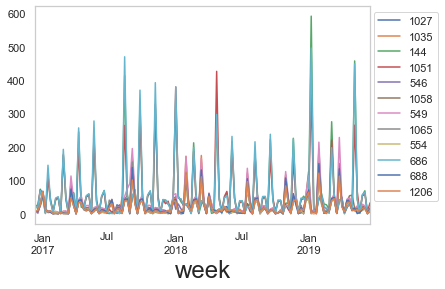

In [38]:
target_wpc = target_s.pct_change().dropna().abs()*100
target_wpc.plot()
plt.legend(bbox_to_anchor=(1.22, 1), loc='upper right', ncol=1)
plt.grid()

In [8]:
target_wpc.abs().describe()

,1027,1035,144,1051,546,1058,549,1065,554,686,688,1206
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,0.237888,0.248123,0.612083,0.559075,0.218004,0.255033,0.307101,0.194727,0.188233,0.622073,0.226954,0.202025
std,0.316285,0.341811,0.972910,0.811908,0.273623,0.335165,0.421467,0.259617,0.232134,1.000022,0.302816,0.256111
min,0.001035,0.001687,0.001286,0.000289,0.000879,0.002844,0.002232,0.000069,0.000342,0.003021,0.000000,0.000448
25%,0.041392,0.036154,0.065185,0.070143,0.041559,0.045413,0.050114,0.027567,0.033748,0.040476,0.038233,0.040334
50%,0.115243,0.116302,0.379211,0.378342,0.114286,0.136689,0.156129,0.081660,0.083831,0.389449,0.112241,0.100698
75%,0.344450,0.387446,0.524130,0.516466,0.322732,0.351628,0.422810,0.320873,0.330285,0.523497,0.362567,0.306707
max,1.924625,1.744487,5.911847,4.260531,1.659897,1.641793,2.283975,1.545659,1.281920,4.957643,1.502019,1.241285


In [9]:
display(target_s.describe())
display(price_s.describe())
display(nos_w1_s.describe())
display(vop_w1_s.describe())

,1027,1035,144,1051,546,1058,549,1065,554,686,688,1206
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,88266.105263,63473.548872,42686.894737,24904.909774,111831.511278,48221.248120,64297.368421,127803.984962,171707.218045,47912.308271,51916.962406,66936.556391
std,46522.584617,35163.843332,28764.506403,15651.284340,53594.949721,25209.250453,40510.106548,54326.256341,75587.706163,32748.755328,26027.371541,28873.913670
min,31329.000000,23594.000000,8653.000000,5505.000000,45488.000000,15199.000000,15990.000000,53773.000000,72960.000000,9113.000000,20590.000000,28292.000000
25%,58909.000000,40921.000000,15958.000000,10399.000000,77903.000000,31308.000000,38346.000000,92841.000000,123494.000000,19163.000000,35285.000000,48193.000000
50%,68544.000000,46158.000000,38457.000000,21979.000000,88557.000000,36281.000000,45176.000000,104824.000000,138360.000000,41500.000000,39185.000000,54660.000000
75%,108807.000000,77317.000000,64206.000000,38686.000000,140448.000000,58225.000000,84176.000000,152681.000000,206982.000000,67126.000000,59194.000000,80842.000000
max,237531.000000,170760.000000,127418.000000,66679.000000,266919.000000,117791.000000,179886.000000,280918.000000,392180.000000,146671.000000,121177.000000,145037.000000


,1027,1035,144,1051,546,1058,549,1065,554,686,688,1206
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,0.487820,0.481353,2.710150,2.715714,0.496090,0.485188,0.481053,0.502105,0.500075,2.710301,0.487068,0.495639
std,0.090674,0.093596,0.696969,0.695328,0.082763,0.092782,0.094671,0.085067,0.079530,0.695356,0.092800,0.089072
min,0.310000,0.310000,1.750000,1.750000,0.330000,0.310000,0.300000,0.330000,0.340000,1.750000,0.310000,0.320000
25%,0.390000,0.380000,2.000000,2.000000,0.410000,0.390000,0.380000,0.420000,0.420000,2.000000,0.390000,0.410000
50%,0.530000,0.530000,2.360000,2.420000,0.540000,0.530000,0.530000,0.540000,0.540000,2.390000,0.530000,0.530000
75%,0.560000,0.550000,3.490000,3.490000,0.560000,0.560000,0.550000,0.560000,0.560000,3.490000,0.560000,0.560000
max,0.570000,0.560000,3.890000,3.890000,0.590000,0.570000,0.560000,0.650000,0.590000,3.890000,0.570000,0.650000


,1027,1035,144,1051,546,1058,549,1065,554,686,688,1206
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,6.560606,4.189394,17.727273,11.075758,5.848485,3.181818,3.234848,9.484848,8.962121,21.257576,3.492424,4.196970
std,10.483908,8.148556,21.948618,14.366852,9.253417,5.021812,5.202553,13.038103,12.459648,24.658467,5.608739,7.494975
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,5.000000,5.000000,2.000000,1.000000,1.000000,3.000000,3.000000,7.000000,1.000000,1.000000
75%,8.500000,3.000000,40.500000,19.000000,5.000000,4.000000,4.000000,9.000000,9.250000,51.000000,4.000000,3.250000
max,44.000000,42.000000,63.000000,65.000000,37.000000,24.000000,23.000000,51.000000,58.000000,70.000000,23.000000,40.000000


,1027,1035,144,1051,546,1058,549,1065,554,686,688,1206
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,50.590094,48.204109,59.991075,60.231542,50.596795,50.697168,48.452436,51.585514,48.766046,60.983749,49.391752,50.703591
std,31.817825,33.755251,47.128562,47.471037,29.182086,32.353619,34.026144,28.492763,28.254745,46.552509,33.331968,31.052272
min,11.526009,14.250546,0.000000,0.000000,10.041824,16.736131,6.196853,15.037533,10.004628,0.000000,15.520831,13.175868
25%,27.221716,24.390992,2.709716,1.771714,29.402507,27.674746,24.042197,29.562428,26.134956,3.239143,23.469191,26.199001
50%,35.230585,30.118184,97.959306,99.403963,38.516216,33.948720,30.277091,39.457826,36.869078,98.747817,32.603333,36.004404
75%,96.368422,98.917526,99.817727,100.000000,91.168735,99.363304,99.036786,87.785323,85.348462,100.000000,99.557440,92.695943
max,100.000000,100.000000,100.000000,100.000000,98.255754,100.000000,100.000000,98.462650,96.077420,100.000000,100.000000,100.000000


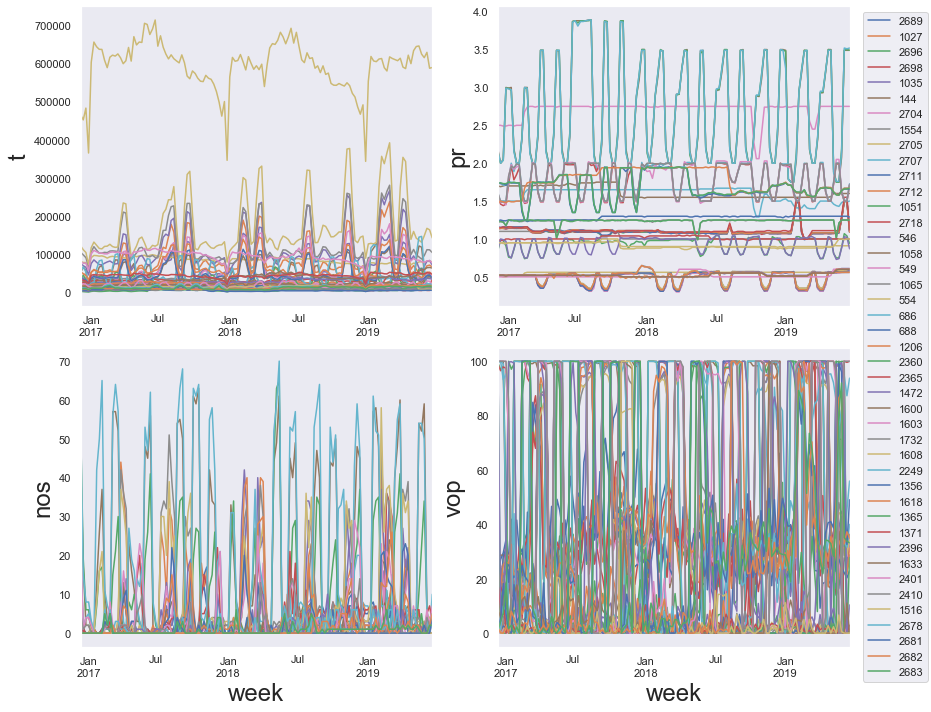

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,10))
target.plot(ax=axes[0,0],legend=False)
axes[0,0].set(xlabel=None, ylabel="t")
price.plot(ax=axes[0,1],legend=False)
axes[0,1].set(xlabel=None, ylabel="pr")
nos_w1.plot(ax=axes[1,0],legend=False)
axes[1,0].set(xlabel="week", ylabel="nos")
vop_w1.plot(ax=axes[1,1],legend=False)
axes[1,1].set(xlabel="week", ylabel="vop")
handles, labels = axes[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',bbox_to_anchor=(1.08, .98))
plt.tight_layout()


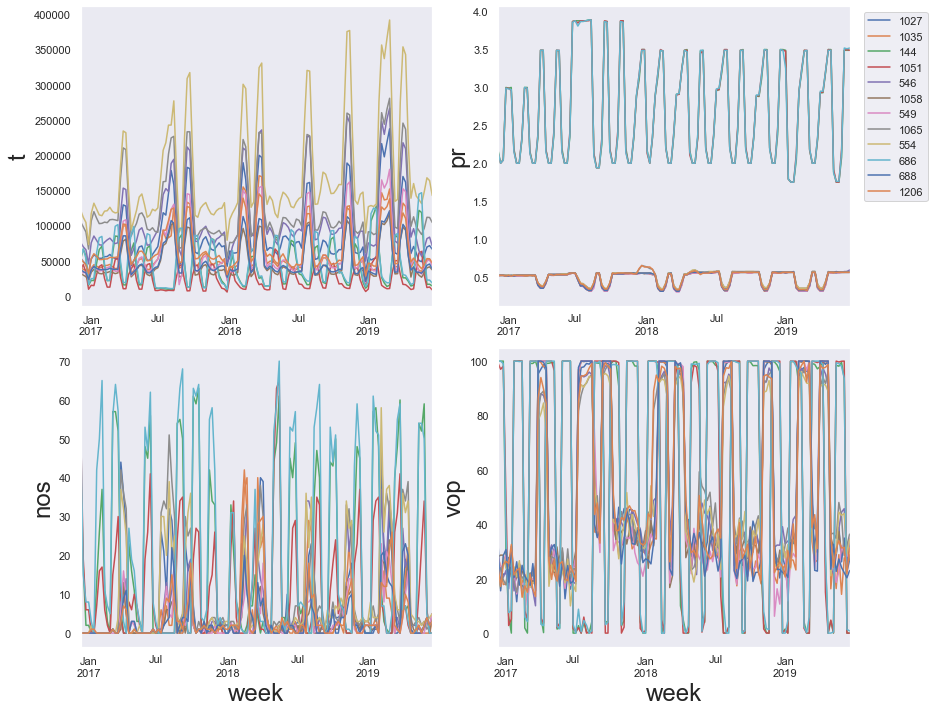

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,10))
target_s.plot(ax=axes[0,0],legend=False)
axes[0,0].set(xlabel=None, ylabel="t")
price_s.plot(ax=axes[0,1],legend=False)
axes[0,1].set(xlabel=None, ylabel="pr")
nos_w1_s.plot(ax=axes[1,0],legend=False)
axes[1,0].set(xlabel="week", ylabel="nos")
vop_w1_s.plot(ax=axes[1,1],legend=False)
axes[1,1].set(xlabel="week", ylabel="vop")
handles, labels = axes[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',bbox_to_anchor=(1.08, .98))
plt.tight_layout()

In [12]:
sku=df['sku'].copy().to_frame()
sku_s=df[df['scope']=='1']['sku'].copy().to_frame()
sku_features=['pack', 'size', 'brand','scope']
for features in sku_features:
    sku[features]=df[features].copy()
    sku_s[features]=df[features].copy()

sku.drop_duplicates(inplace=True)
sku_s.drop_duplicates(inplace=True)
sku.set_index('sku',inplace=True)
sku_s.set_index('sku',inplace=True)


try:
    sku['pack_n']=sku['pack'].replace(['SINGLE','MULTI'], [0,1]).apply(int)
except:
    pass
try:
    sku['brand_n']=sku['brand'].map(lambda x: x.lstrip('BRAND')).apply(int)-1
except:
    pass

time_series=['target','price','nos_w1','vop_w1']
for ts in time_series:
    sku[str(ts)+'_mean']=eval(ts).mean()
    sku[str(ts)+'_std']=eval(ts).std()

def ADFuller(df):
    index=df.index
    columns = df.columns
    df_stats = pd.DataFrame(columns=['p-value'], index=columns)
    for col in columns:
        df_stats.loc[col]=adfuller(df[col], autolag='AIC')[1]
    return df_stats
sku['adf']=ADFuller(target)['p-value'].apply(float)

C:\Users\asus\miniconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


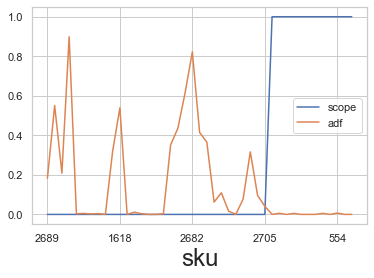

In [47]:
sku[['scope','adf']].sort_values(by=['scope']).plot()

Text(0.5, 1.04, 'Pearson Correlation between Means of Time Series')

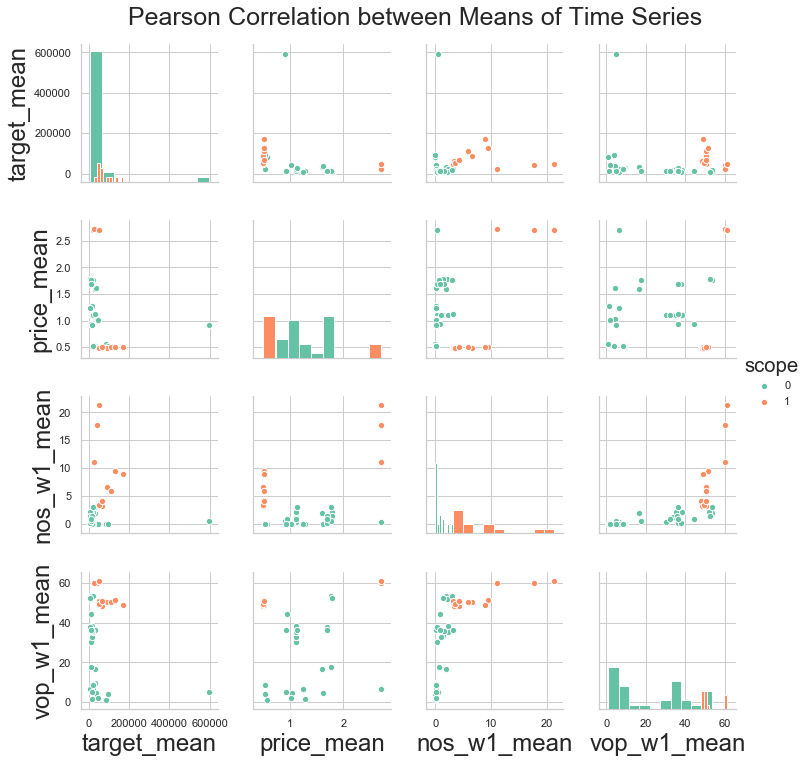

In [13]:
sns.set_style("whitegrid", {'axes.grid' : True})
g=sns.PairGrid(sku[['scope', 'target_mean', 'price_mean', 'nos_w1_mean','vop_w1_mean']],
               hue='scope',palette="Set2")
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Means of Time Series",y=1.04, fontsize=25)

Text(0.5, 1.04, 'Pearson Correlation between Std. Deviations of Time Series')

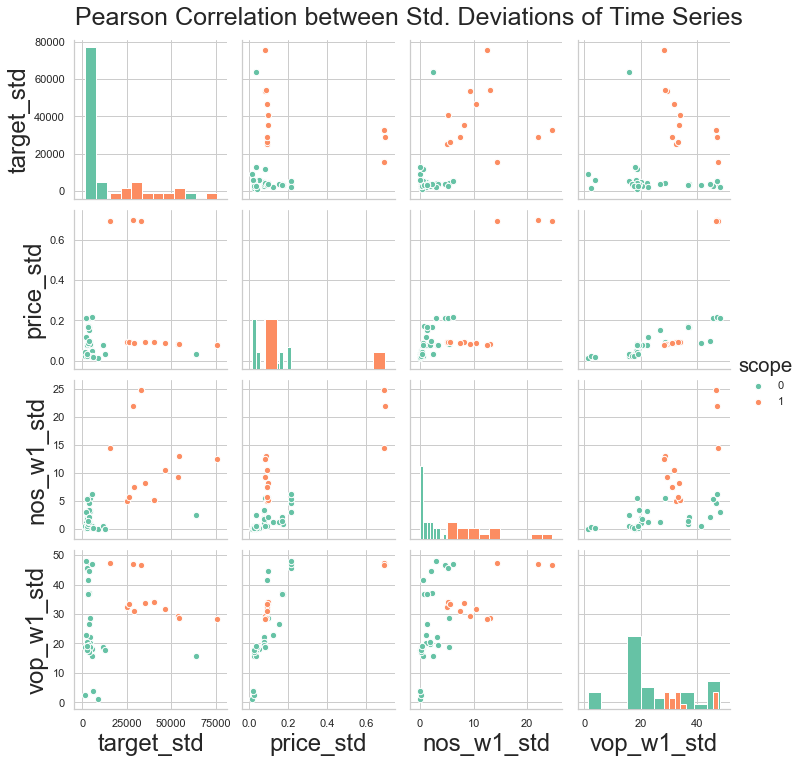

In [14]:
sns.set_style("whitegrid", {'axes.grid' : True})
g=sns.PairGrid(sku[['scope',  'target_std', 'price_std', 'nos_w1_std', 'vop_w1_std']],
               hue='scope',palette="Set2");
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Std. Deviations of Time Series",y=1.04, fontsize=25)

In [15]:
def autocorrelation(Xi):
    k=35
    autoCov = np.zeros((k))
    Xs=np.mean(Xi)
    N=len(Xi)
    for j in range(k):
        for i in np.arange(0, N-j):
            autoCov[j] += ((Xi[i+j])-Xs)*(Xi[i]-Xs)
    return (autoCov/autoCov[0])

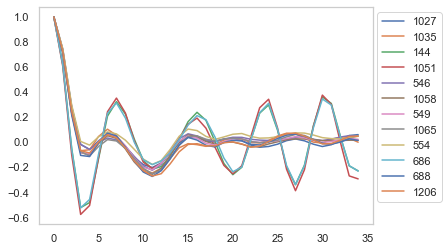

In [16]:
target_s.apply(autocorrelation).plot()
plt.legend(bbox_to_anchor=(1.22, 1), loc='upper right', ncol=1)
plt.grid()

In [17]:
for index,row in skus.items():
    sku.loc[row,'price_target']=pearsonr(target[row],price[row])[0]
    sku.loc[row,'nos-w1_target']=pearsonr(nos_w1[row],target[row][1:])[0]
    sku.loc[row,'vop-w1_tar']=pearsonr(vop_w1[row],target[row][1:])[0]
    sku.loc[row,'sales_target']=pearsonr(sales_w1[row],target[row][1:])[0]

C:\Users\asus\miniconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, 1.04, 'Pearson Correlation between Time Series')

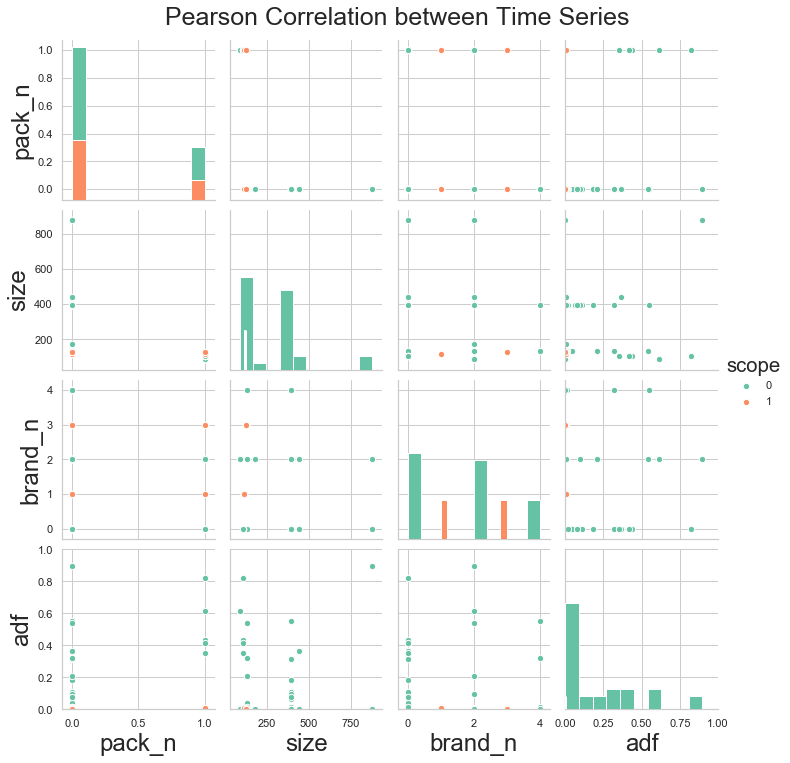

In [18]:
sns.set_style("whitegrid", {'axes.grid' : True})
g=sns.PairGrid(sku[['scope','pack_n', 'size', 'brand_n', 'adf']],
               hue='scope',palette="Set2");
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g.axes[3,0].set_ylim(0,1)
g.axes[0,3].set_xlim(0,1)
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Time Series",y=1.04, fontsize=25)

C:\Users\asus\miniconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, 1.04, 'Pearson Correlation between Time Series')

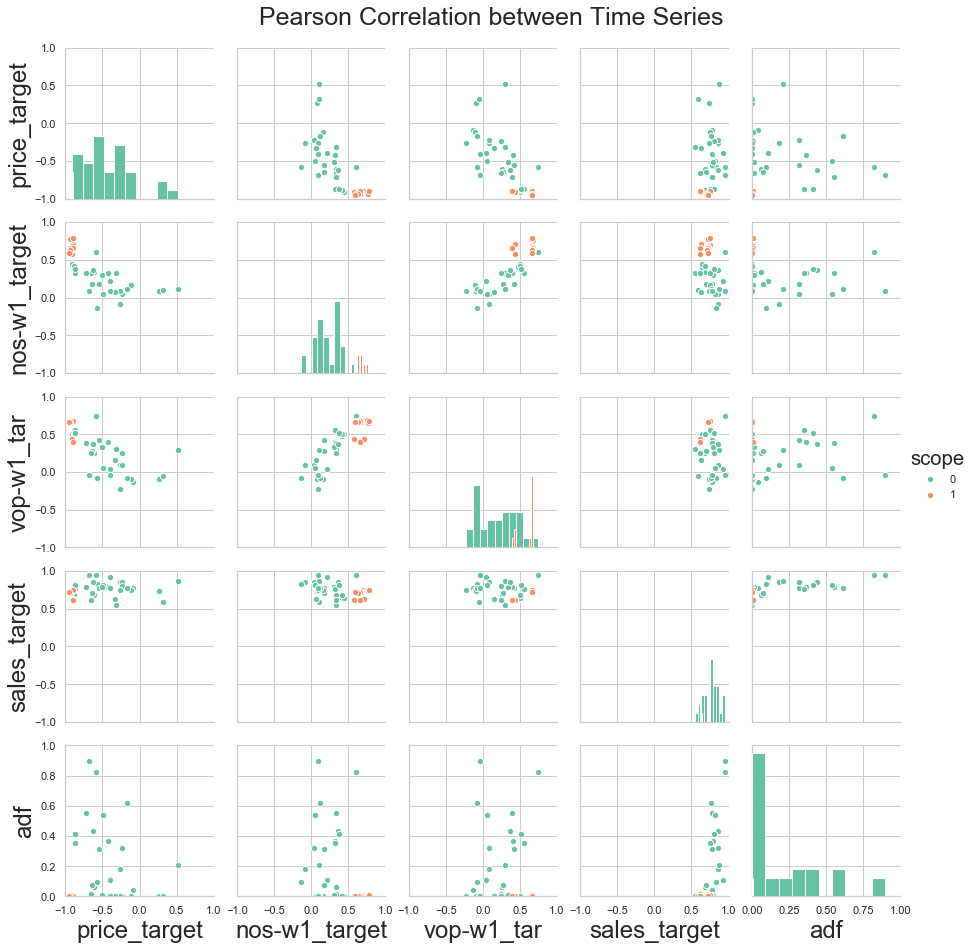

In [19]:
for index,row in skus.items():
    sku.loc[row,'price_target']=pearsonr(target[row],price[row])[0]
    sku.loc[row,'nos-w1_target']=pearsonr(nos_w1[row],target[row][1:])[0]
    sku.loc[row,'vop-w1_tar']=pearsonr(vop_w1[row],target[row][1:])[0]
    sku.loc[row,'sales_target']=pearsonr(sales_w1[row],target[row][1:])[0]
sns.set_style("whitegrid", {'axes.grid' : True})
g=sns.PairGrid(sku[['scope', 'price_target', 'nos-w1_target', 'vop-w1_tar','sales_target','adf']],
               hue='scope',palette="Set2");
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g.set(xlim=(-1,1), ylim = (-1,1))
g.axes[4,0].set_ylim(0,1)
g.axes[0,4].set_xlim(0,1)
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Time Series",y=1.04, fontsize=25)


    

In [20]:
def rangeSize(size):
    if size<300:
        return 'small'
    elif size<600:
        return 'medium'
    else:
        return 'big'
sku['size_class']=sku['size'].apply(rangeSize)

Text(0.5, 1.04, 'Pearson Correlation between Time Series')

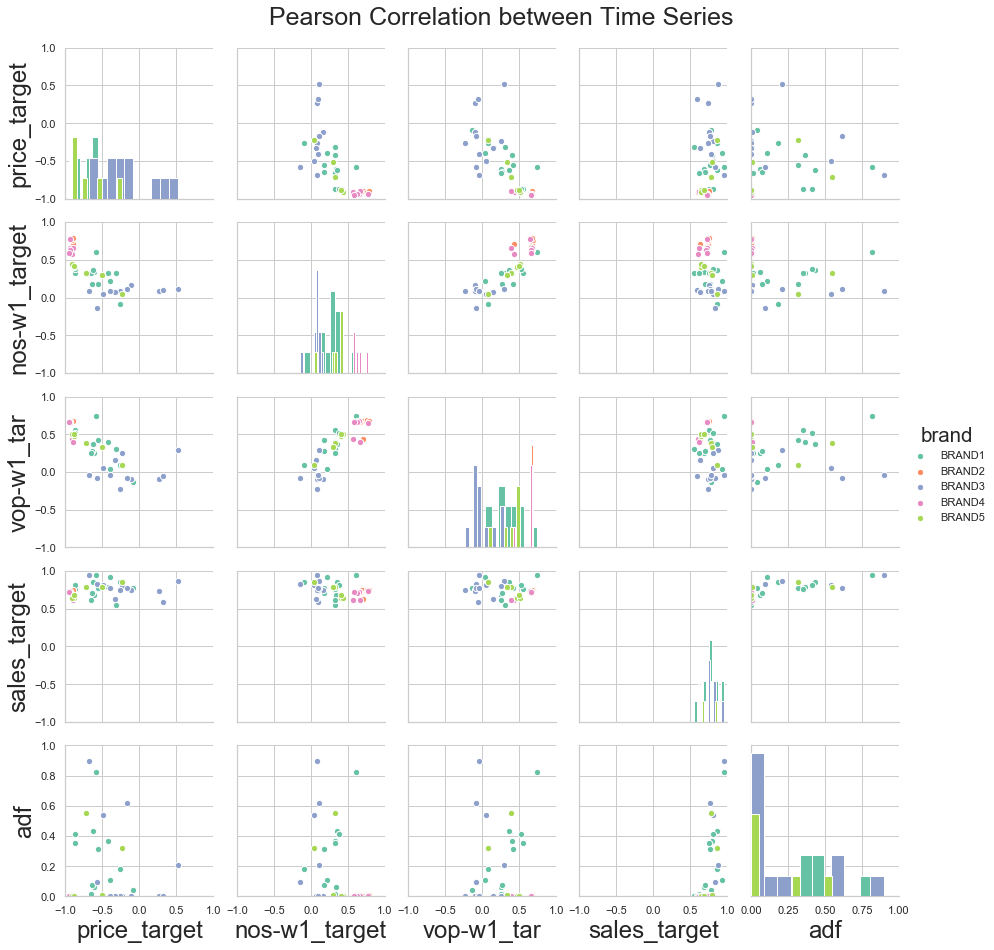

In [21]:
g=sns.PairGrid(sku[['brand', 'price_target', 'nos-w1_target', 'vop-w1_tar','sales_target','adf']],
               hue='brand',palette="Set2");
sns.set_style("whitegrid", {'axes.grid' : True})
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g.set(xlim=(-1,1), ylim = (-1,1))
g.axes[4,0].set_ylim(0,1)
g.axes[0,4].set_xlim(0,1)
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Time Series",y=1.04, fontsize=25)

Text(0.5, 1.04, 'Pearson Correlation between Time Series')

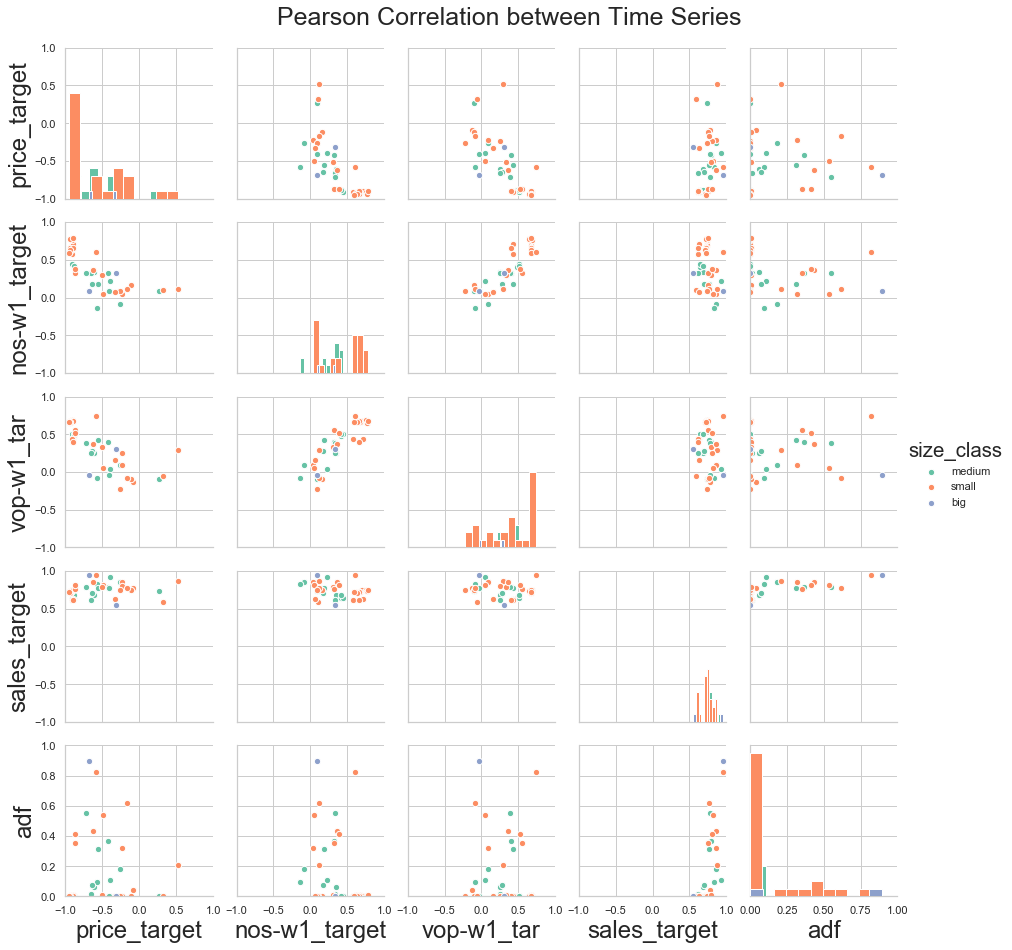

In [22]:
g=sns.PairGrid(sku[['size_class', 'price_target', 'nos-w1_target', 'vop-w1_tar','sales_target','adf']],
               hue='size_class',palette="Set2");
sns.set_style("whitegrid", {'axes.grid' : True})
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g.set(xlim=(-1,1), ylim = (-1,1))
g.axes[4,0].set_ylim(0,1)
g.axes[0,4].set_xlim(0,1)
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Time Series",y=1.04, fontsize=25)

Text(0.5, 1.04, 'Pearson Correlation between Time Series')

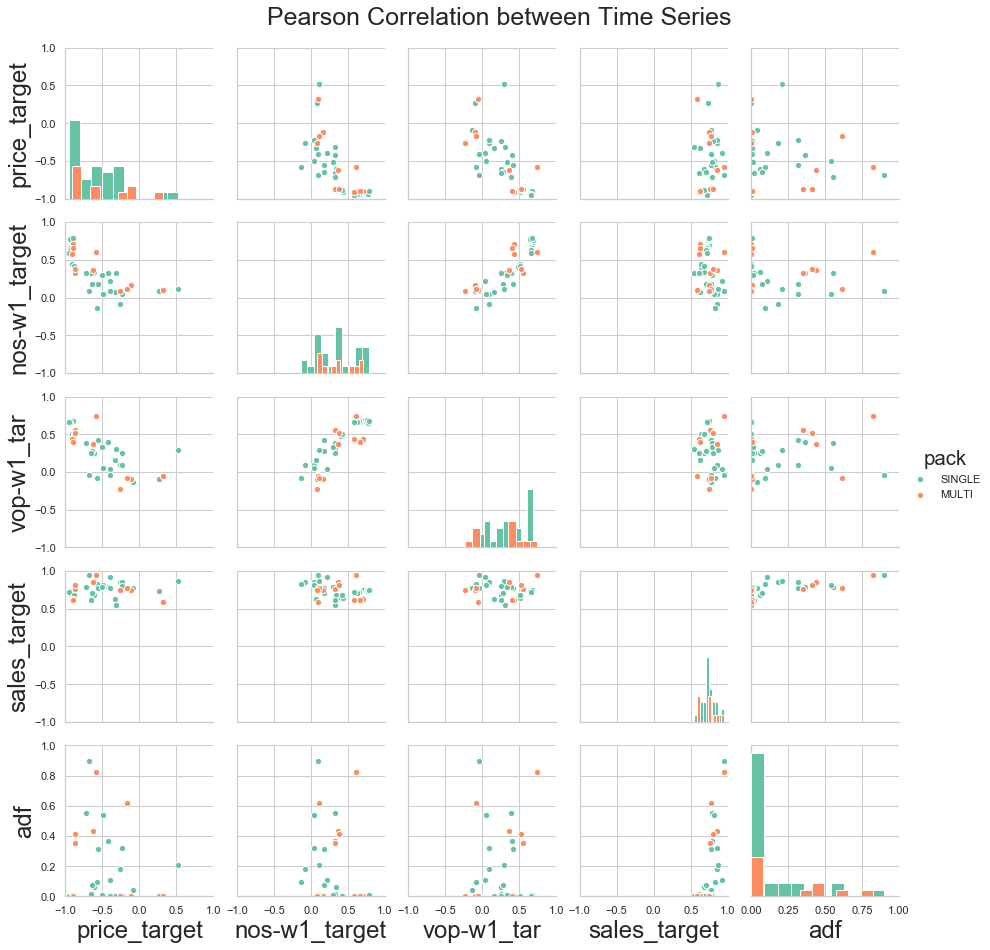

In [23]:
g=sns.PairGrid(sku[['pack', 'price_target', 'nos-w1_target', 'vop-w1_tar','sales_target','adf']],
               hue='pack',palette="Set2");
sns.set_style("whitegrid", {'axes.grid' : True})
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g.set(xlim=(-1,1), ylim = (-1,1))
g.axes[4,0].set_ylim(0,1)
g.axes[0,4].set_xlim(0,1)
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Time Series",y=1.04, fontsize=25)

In [87]:
lags=20
variables=['price[row].shift(lag).dropna()', 'nos_w1[row].shift(lag).dropna()',
           'vop_w1[row].shift(lag).dropna()','sales_w1[row].shift(lag).dropna()','target[row].shift(lag).dropna()']
targets=['target[row][lag:]','target[row][lag+1:]','target[row][lag+1:]','target[row][lag+1:]','target[row][lag:]']
max_corrs=pd.DataFrame()
for lag in range(0,lags+1):
    for variable,t in zip(variables,targets):
        pearsons=np.ones((target.shape[1]))*np.nan
        for i,row in skus.iteritems():
            pearsons[i]=pearsonr(eval(t),eval(variable))[0]
        max_corrs.loc[lag,variable]=max(np.nanmin(pearsons), np.nanmax(pearsons), key=abs)
max_corrs.rename(columns={variables[0]:'price / t',variables[1]:'NOS_w-1 / t',variables[2]:'VOP_w-1 / t',
                          variables[3]:'sales_w-1 / t',variables[4]:'t_lag / t'},inplace=True)


C:\Users\asus\miniconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, 1, 'Maximum Pearson Correlation of Time Series among SKUs w.r.t. the target. All SKUs')

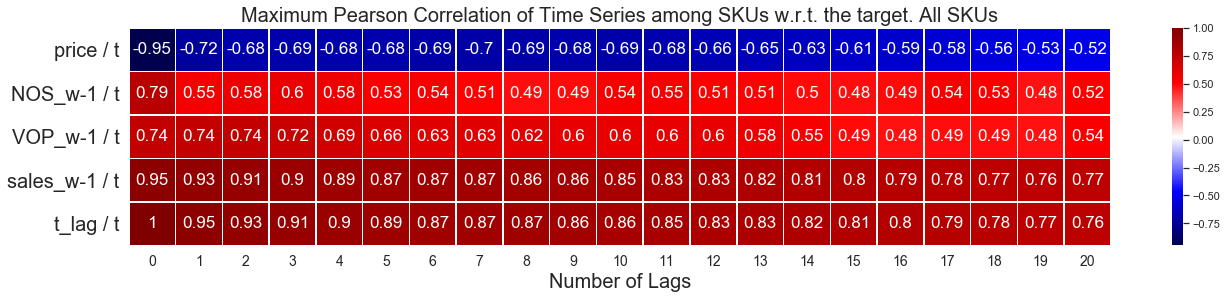

In [88]:
f, ax = plt.subplots(figsize=(22, 4))
sns.heatmap(max_corrs.T, annot=True, linewidths=.5, ax=ax, cmap="seismic", annot_kws={"size": 17})
plt.xlabel('Number of Lags',fontsize=20)
plt.ylabel('',fontsize=20,labelpad=40)
plt.yticks(fontsize=20)
plt.xticks(fontsize=14)
plt.title('Maximum Pearson Correlation of Time Series among SKUs w.r.t. the target. All SKUs',fontsize=20)

In [89]:
lags=20
variables=['price_s[row].shift(lag).dropna()', 'nos_w1_s[row].shift(lag).dropna()',
           'vop_w1_s[row].shift(lag).dropna()','sales_w1_s[row].shift(lag).dropna()','target_s[row].shift(lag).dropna()']
targets=['target_s[row][lag:]','target_s[row][lag+1:]','target_s[row][lag+1:]','target_s[row][lag+1:]','target_s[row][lag:]']
max_corrs=pd.DataFrame()
for lag in range(0,lags+1):
    for variable,t in zip(variables,targets):
        pearsons=np.ones((target_s.shape[1]))*np.nan
        for i,row in skus_s.iteritems():
            pearsons[i]=pearsonr(eval(t),eval(variable))[0]
        max_corrs.loc[lag,variable]=max(np.nanmin(pearsons), np.nanmax(pearsons), key=abs)
max_corrs.rename(columns={variables[0]:'price / t',variables[1]:'NOS_w-1 / t',variables[2]:'VOP_w-1 / t',
                          variables[3]:'sales_w-1 / t',variables[4]:'t_lag / t'},inplace=True)


Text(0.5, 1, 'Maximum Pearson Correlation of Time Series among SKUs w.r.t. the target. Scope SKUs')

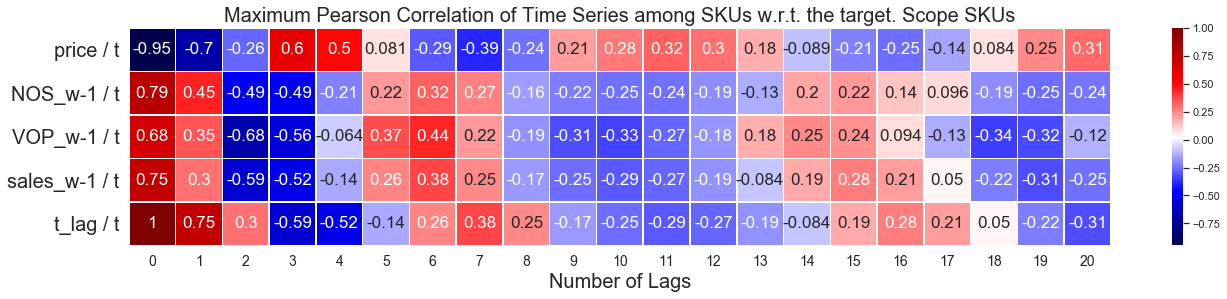

In [90]:
f, ax = plt.subplots(figsize=(22, 4))
sns.heatmap(max_corrs.T, annot=True, linewidths=.5, ax=ax, cmap="seismic", annot_kws={"size": 17})
plt.xlabel('Number of Lags',fontsize=20)
plt.ylabel('',fontsize=20,labelpad=40)
plt.yticks(fontsize=20)
plt.xticks(fontsize=14)
plt.title('Maximum Pearson Correlation of Time Series among SKUs w.r.t. the target. Scope SKUs',fontsize=20)

In [373]:
lags=2
variables=['price[row].shift(lag).dropna()', 'nos_w1[row].shift(lag).dropna()',
           'vop_w1[row].shift(lag).dropna()','sales_w1[row].shift(lag).dropna()']
names=['price', 'nos_w1','vop_w1','sales_w1']
targets=['target[row][lag:]','target[row][lag+1:]','target[row][lag+1:]','target[row][lag+1:]']
for lag in range(0,lags+1):
    for variable,t,name in zip(variables,targets,names):
        pearsons=np.ones((target.shape[1]))*np.nan
        for i,row in skus.iteritems():
            pearsons[i]=pearsonr(eval(t),eval(variable))[0]
        sku[name+'_'+str(lag)]=pearsons

C:\Users\asus\miniconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [300]:
sku.columns

Index(['pack', 'size', 'brand', 'scope', 'pack_n', 'brand_n', 'target_mean',
       'target_std', 'price_mean', 'price_std', 'nos_w1_mean', 'nos_w1_std',
       'vop_w1_mean', 'vop_w1_std', 'adf', 'price_0', 'nos_w1_0', 'vop_w1_0',
       'sales_w1_0', 'price_1', 'nos_w1_1', 'vop_w1_1', 'sales_w1_1',
       'price_2', 'nos_w1_2', 'vop_w1_2', 'sales_w1_2'],
      dtype='object')

Text(0.5, 1.04, 'Pearson Correlation between Time Series')

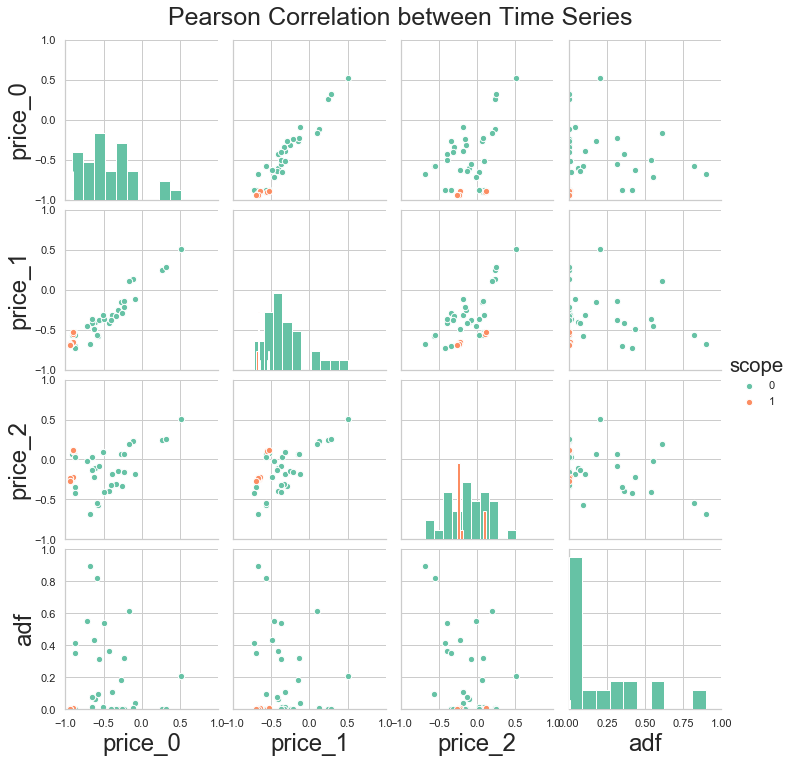

In [256]:
sns.set_style("whitegrid", {'axes.grid' : True})
g=sns.PairGrid(sku[['scope','price_0',  'price_1', 'price_2','adf']],
               hue='scope',palette="Set2");
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g.set(xlim=(-1,1), ylim = (-1,1))
g.axes[3,0].set_ylim(0,1)
g.axes[0,3].set_xlim(0,1)
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Time Series",y=1.04, fontsize=25)

Text(0.5, 1.04, 'Pearson Correlation between Time Series')

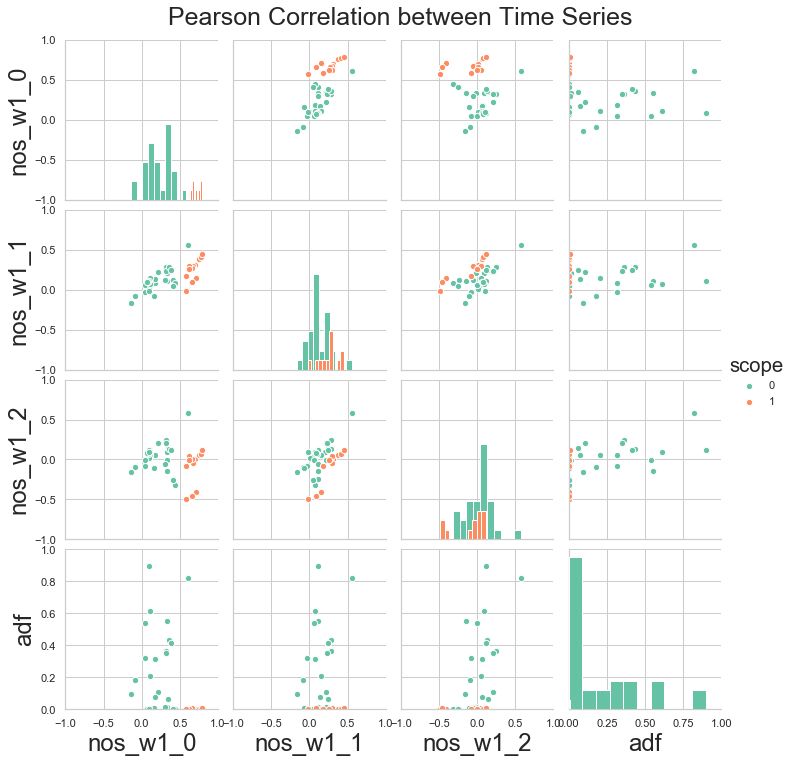

In [257]:
sns.set_style("whitegrid", {'axes.grid' : True})
g=sns.PairGrid(sku[['scope','nos_w1_0',  'nos_w1_1', 'nos_w1_2', 'adf']],
               hue='scope',palette="Set2");
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g.set(xlim=(-1,1), ylim = (-1,1))
g.axes[3,0].set_ylim(0,1)
g.axes[0,3].set_xlim(0,1)
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Time Series",y=1.04, fontsize=25)

Text(0.5, 1.04, 'Pearson Correlation between Time Series')

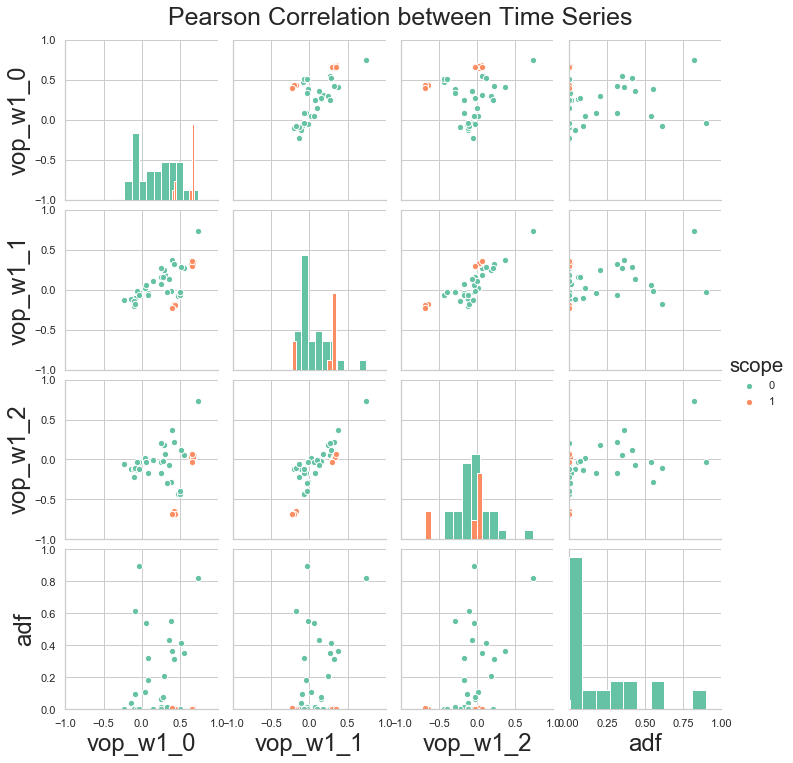

In [258]:
sns.set_style("whitegrid", {'axes.grid' : True})
g=sns.PairGrid(sku[['scope','vop_w1_0',  'vop_w1_1', 'vop_w1_2', 'adf']],
               hue='scope',palette="Set2");
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g.set(xlim=(-1,1), ylim = (-1,1))
g.axes[3,0].set_ylim(0,1)
g.axes[0,3].set_xlim(0,1)
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Time Series",y=1.04, fontsize=25)

Text(0.5, 1.04, 'Pearson Correlation between Time Series')

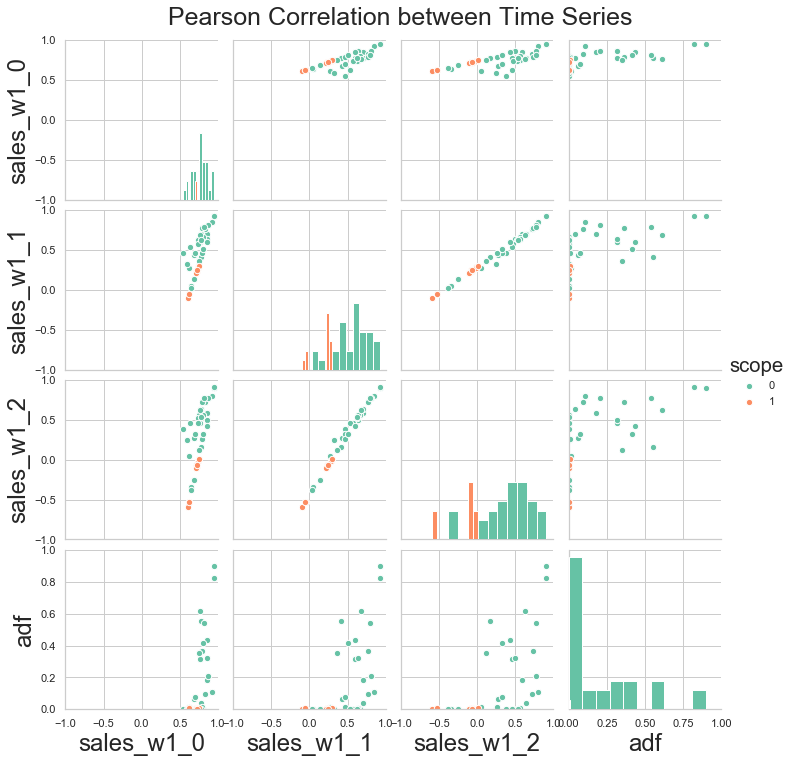

In [259]:
sns.set_style("whitegrid", {'axes.grid' : True})
g=sns.PairGrid(sku[['scope','sales_w1_0',  'sales_w1_1', 'sales_w1_2', 'adf']],
               hue='scope',palette="Set2");
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g.set(xlim=(-1,1), ylim = (-1,1))
g.axes[3,0].set_ylim(0,1)
g.axes[0,3].set_xlim(0,1)
g = g.add_legend() 
g.fig.suptitle("Pearson Correlation between Time Series",y=1.04, fontsize=25)